In [ ]:
pip install deep_translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from deep_translator import GoogleTranslator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import json


d1_path = 'mendley_data.xlsx'
d2_path = 'kaggle_data.csv'


d1 = pd.read_excel(d1_path, sheet_name='Data', engine='openpyxl')
d2 = pd.read_csv(d2_path)


breed_mapping = {
    'BEN': 'Bengal',
    'SBI': 'Birman',
    'BRI': 'British Shorthair',
    'CHA': 'Chartreux',
    'EUR': 'European',
    'MCO': 'Maine coon',
    'PER': 'Persian',
    'RAG': 'Ragdoll',
    'SPH': 'Savannah',
    'ORI': 'Sphynx',
    'TUV': 'Siamese',
    'Autre': 'Other'
}
age_mapping = {
    'Moinsde1': 0.5,
    '1a2': 1.5,
    '2a10': 6,
    'Plusde10': 11
}

number_mapping = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'Plusde5': 5
}

sex_mapping = {
    'M': 'M',
    'F': 'F'
}

housing_mapping = {
    'ASB': 'ASB',
    'AAB': 'AAB',
    'ML': 'ML',
    'MI': 'MI'
}

zone_mapping = {
    'U': 'U',
    'PU': 'PU',
    'R': 'R'
}

outdoor_time_mapping = {
    '1': 1, '2': 2, '3': 3, '4': 4, '5': 5
}

interaction_time_mapping = {
    '1': 1, '2': 2, '3': 3, '4': 4
}

abundance_mapping = {
    '1': 1, '2': 2, '3': 3, 'NSP': 0
}

bird_capture_mapping = {
    '1': 1, '2': 2, '3': 3, '4': 4, '5': 5
}

mammal_capture_mapping = {
    '1': 1, '2': 2, '3': 3, '4': 4, '5': 5
}

default_mapping_values = {
    'Race': 'Other',
    'Number': 1,
    'Age': 1,
    'Sex': 'F',
    'Accommodation': 'ASB',
    'Area': 'U',
    'Ext': 1,
    'Obs': 1,
    'Abundance': 1,
    'PredBird': 1,
    'PredMamm': 1
}

mapping_dict = {
    'Race': breed_mapping,
    'Number': number_mapping,
    'Age': age_mapping,
    'Sex': sex_mapping,
    'Accommodation': housing_mapping,
    'Area': zone_mapping,
    'Ext': outdoor_time_mapping,
    'Obs': interaction_time_mapping,
    'Abundance': abundance_mapping,
    'PredBird': bird_capture_mapping,
    'PredMamm': mammal_capture_mapping
}



translator = GoogleTranslator(source='fr', target='en')
d1.columns = [translator.translate(col) for col in d1.columns]


optional_columns = ["Row.names", "Time stamp", "More"]
d1 = d1.drop(columns=[col for col in optional_columns if col in d1.columns], errors='ignore')



for column, mapping in mapping_dict.items():
    if column in d1.columns:
        d1[column] = d1[column].apply(
            lambda x: mapping.get(x, default_mapping_values[column]) if pd.notnull(x) else np.nan
        )

d1_cleaned = d1.drop_duplicates()
d1_cleaned = d1_cleaned.rename(columns={'Race': 'Breed'})
d2.rename(columns={'name': 'Breed'}, inplace=True)
d1_breeds = d1_cleaned['Breed'].unique()
d2_breeds = d2['Breed'].unique()

d1_cleaned['Breed'] = d1_cleaned['Breed'].apply(lambda x: breed_mapping.get(x, 'Other'))
#d2['Breed'] = d2['Breed'].apply(lambda x: breed_mapping.get(x, 'Other'))


unmapped_breeds_d1 = [breed for breed in d1_breeds if breed not in breed_mapping.keys()]
unmapped_breeds_d2 = [breed for breed in d2_breeds if breed not in breed_mapping.keys()]


for unmapped in unmapped_breeds_d1 + unmapped_breeds_d2:
    breed_mapping[unmapped] = 'Other'


merged_df = pd.merge(d1_cleaned, d2, on='Breed', how='outer')



categorical_columns = merged_df.select_dtypes(include=['object']).columns
category_mappings = {}
label_to_origin_mapping = {}

for col in categorical_columns:

    categories = merged_df[col].dropna().unique()
    category_mapping = {category: code for code, category in enumerate(categories)}
    category_mappings[col] = category_mapping

    merged_df[col] = pd.Categorical(merged_df[col], categories=merged_df[col].dropna().unique(), ordered=False)
    merged_df[col] = merged_df[col].cat.codes.replace(-1, np.nan)

    if col == 'origin':
        label_to_origin_mapping = {code: category for category, code in category_mapping.items()}

for col, mapping in category_mappings.items():
    if col in merged_df.columns:
        reverse_mapping = {v: k for k, v in mapping.items()}

breed_mapping_2 = category_mappings.get('Breed', {})
print(f"Breed mapping: {breed_mapping_2}")
breed_to_label = {breed: label for breed, label in breed_mapping_2.items()}
label_to_breed = {label: breed for breed, label in breed_mapping_2.items()}

print("Breed to Label Mapping:")
print(breed_to_label)

print("Label to Breed Mapping:")
print(label_to_breed)

with open('label_to_origin_mapping.json', 'w') as json_file:
    json.dump(label_to_origin_mapping, json_file)
print("Label to Origin Mapping saved as 'label_to_origin_mapping.json'.")

missing_cols = merged_df.columns[merged_df.isna().any()].tolist()
complete_cols = [col for col in merged_df.columns if col not in missing_cols]


def train_model_for_missing_value(column_name):
    train_df = merged_df[merged_df[column_name].notnull()]
    X = train_df.loc[train_df.index, complete_cols]
    y = train_df[column_name]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

    model = RandomForestRegressor(n_estimators=100, random_state=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    return model, mse



def augment_dataset(df, column_name, model):
    nan_rows = df[df[column_name].isna()]

    X_nan = df.loc[nan_rows.index, complete_cols]

    if not X_nan.empty:
        predicted_values = model.predict(X_nan)
        df.loc[df[column_name].isna(), column_name] = predicted_values
        print(f"Filled missing values for column: {column_name}")


numeric_missing_cols = [col for col in missing_cols if col in merged_df.columns]
results = {}
augmented_df = merged_df.copy()

for col in numeric_missing_cols:

    model, mse = train_model_for_missing_value(col)
    results[col] = {"model": model, "mse": mse}

    augment_dataset(augmented_df, col, model)


numeric_columns = augmented_df.select_dtypes(include=['float64', 'int64']).columns
augmented_df[numeric_columns] = augmented_df[numeric_columns].round(0).astype(int)


augmented_df.to_csv('augmented_dataset.csv', index=False)
print("Augmented dataset saved as 'augmented_dataset.csv'.")


Breed mapping: {'Abyssinian': 0, 'Aegean': 1, 'American Bobtail': 2, 'American Shorthair': 3, 'American Wirehair': 4, 'Aphrodite Giant': 5, 'Arabian Mau': 6, 'Asian': 7, 'Australian Mist': 8, 'Bambino': 9, 'Bengal': 10, 'Bengal Cats': 11, 'Birman': 12, 'Bombay': 13, 'Brazilian Shorthair': 14, 'British Longhair': 15, 'British Shorthair': 16, 'Burmese': 17, 'Burmilla': 18, 'California Spangled': 19, 'Chantilly-Tiffany': 20, 'Chartreux': 21, 'Chausie': 22, 'Colorpoint Shorthair': 23, 'Cornish Rex': 24, 'Cyprus': 25, 'Devon Rex': 26, 'Donskoy': 27, 'European': 28, 'European Shorthair': 29, 'Foldex': 30, 'German Rex': 31, 'Highlander': 32, 'Japanese Bobtail': 33, 'Javanese': 34, 'Khao Manee': 35, 'Kurilian Bobtail': 36, 'Lykoi': 37, 'Maine Coon': 38, 'Maine coon': 39, 'Manx': 40, 'Mekong Bobtail': 41, 'Nebelung': 42, 'Oriental Bicolor': 43, 'Other': 44, 'Persian': 45, 'Peterbald': 46, 'Pixie-Bob': 47, 'Ragdoll': 48, 'Ragdoll Cats': 49, 'Russian Blue': 50, 'Savannah': 51, 'Scottish Fold': 52

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

augmented_data_path = 'augmented_dataset.csv'
augmented_df = pd.read_csv(augmented_data_path)


X = augmented_df.drop(columns=['Breed']).values
Y = augmented_df['Breed'].values


X = X / np.max(X, axis=0)


def convert_labels(labels):
    labels = np.array(labels).astype(int)
    classes = np.unique(labels).shape[0]
    matrix = np.zeros((labels.shape[0], classes))
    matrix[np.arange(labels.shape[0]), labels] = 1
    return matrix

Y = convert_labels(Y)



train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=50)


np.random.seed(50)
input_size = train_X.shape[1]
hidden_layer_1 = 150
hidden_layer_2 = 100
classes = train_Y.shape[1]
print(f"Number of unique breeds: {classes}")
dropout_rate = 0.2
reg_lambda = 0.0002

W1 = np.random.randn(input_size, hidden_layer_1) * np.sqrt(2 / input_size)
b1 = np.zeros((1, hidden_layer_1))
W2 = np.random.randn(hidden_layer_1, hidden_layer_2) * np.sqrt(2 / hidden_layer_1)
b2 = np.zeros((1, hidden_layer_2))
W3 = np.random.randn(hidden_layer_2, classes) * np.sqrt(2 / hidden_layer_2)
b3 = np.zeros((1, classes))


def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / exp_z.sum(axis=1, keepdims=True)


def cross_entropy_loss(y, y_pred):
    eps = 1e-8
    return -np.sum(y * np.log(y_pred + eps)) / y.shape[0]


def gradient_descent(X, y, W1, b1, W2, b2, W3, b3, learning_rate):

    z1 = relu(X @ W1 + b1)
    z1 = apply_dropout(z1, dropout_rate)

    z2 = relu(z1 @ W2 + b2)
    z2 = apply_dropout(z2, dropout_rate)

    y_pred = softmax(z2 @ W3 + b3)


    loss = cross_entropy_loss(y, y_pred)
    loss += reg_lambda * (np.sum(W1**2) + np.sum(W2**2) + np.sum(W3**2)) # sqrt?


    err_output = y_pred - y

    dW3 = z2.T @ err_output / X.shape[0] + reg_lambda * W3
    db3 = np.sum(err_output, axis=0, keepdims=True) / X.shape[0]

    err_hidden_2 = (err_output @ W3.T) * relu_derivative(z2)
    dW2 = z1.T @ err_hidden_2 / X.shape[0] + reg_lambda * W2
    db2 = np.sum(err_hidden_2, axis=0, keepdims=True) / X.shape[0]

    err_hidden_1 = (err_hidden_2 @ W2.T) * relu_derivative(z1)
    dW1 = X.T @ err_hidden_1 / X.shape[0] + reg_lambda * W1
    db1 = np.sum(err_hidden_1, axis=0, keepdims=True) / X.shape[0]

    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

    return W1, b1, W2, b2, W3, b3, loss


def update_learning_rate(epoch, current_loss, best_loss, lr, threshold, decay_factor, min_lr, epochs_since_improvement):
    if current_loss < best_loss:
        best_loss = current_loss
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    if epochs_since_improvement >= threshold:
        lr = max(lr * (decay_factor ** epoch), min_lr)
        epochs_since_improvement = 0

    return lr, best_loss, epochs_since_improvement


def apply_dropout(A, rate):
    mask = np.random.binomial(1, 1 - rate, size=A.shape)
    return A * mask / (1 - rate)


def accuracy(X, y, W1, b1, W2, b2, W3, b3):

    z1 = relu(X @ W1 + b1)
    z2 = relu(z1 @ W2 + b2)
    y_pred = softmax(z2 @ W3 + b3)

    predicted_classes = np.argmax(y_pred, axis=1)
    true_classes = np.argmax(y, axis=1)
    return np.mean(predicted_classes == true_classes)


def train_with_scheduler(train_X, train_Y, test_X, test_Y, W1, b1, W2, b2, W3, b3, epochs, batch_size, initial_lr, threshold, decay_factor, min_lr):
    num_batches = np.ceil(train_X.shape[0] / batch_size).astype(int)
    lr = initial_lr
    best_loss = float('inf')
    epochs_since_improvement = 0

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        shuffle_indices = np.random.permutation(train_X.shape[0])
        train_X_shuffled = train_X[shuffle_indices]
        train_Y_shuffled = train_Y[shuffle_indices]

        epoch_loss = 0
        for i in range(num_batches):
            start = i * batch_size
            end = min(start + batch_size, train_X.shape[0])
            X_batch = train_X_shuffled[start:end]
            y_batch = train_Y_shuffled[start:end]

            W1, b1, W2, b2, W3, b3, batch_loss = gradient_descent(X_batch, y_batch, W1, b1, W2, b2, W3, b3, learning_rate=lr)
            epoch_loss += batch_loss

        epoch_loss /= num_batches

        lr, best_loss, epochs_since_improvement = update_learning_rate(
            epoch, epoch_loss, best_loss, lr, threshold, decay_factor, min_lr, epochs_since_improvement
        )

        train_losses.append(epoch_loss)
        test_loss = cross_entropy_loss(test_Y, softmax(relu(relu(test_X @ W1 + b1) @ W2 + b2) @ W3 + b3))
        test_losses.append(test_loss)

        train_acc = accuracy(train_X, train_Y, W1, b1, W2, b2, W3, b3)
        val_acc = accuracy(test_X, test_Y, W1, b1, W2, b2, W3, b3)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {test_loss:.4f}, Learning Rate: {lr:.6f}")
        print(f"Training Accuracy: {train_acc * 100:.2f}%, Validation Accuracy: {val_acc * 100:.2f}%\n")

    return W1, b1, W2, b2, W3, b3, train_losses, test_losses


W1, b1, W2, b2, W3, b3, train_losses, test_losses = train_with_scheduler(
    train_X, train_Y, test_X, test_Y,
    W1, b1, W2, b2, W3, b3,
    epochs=100, batch_size=100, initial_lr=0.2, threshold=3, decay_factor=0.2, min_lr=0.01
)


test_accuracy = accuracy(test_X, test_Y, W1, b1, W2, b2, W3, b3)
print(f"Testing Data Accuracy: {test_accuracy * 100:.2f}%")



Number of unique breeds: 68
Epoch 1/100, Loss: 2.5805, Validation Loss: 1.6158, Learning Rate: 0.200000
Training Accuracy: 61.50%, Validation Accuracy: 59.53%

Epoch 2/100, Loss: 1.5928, Validation Loss: 1.1486, Learning Rate: 0.200000
Training Accuracy: 69.33%, Validation Accuracy: 67.34%

Epoch 3/100, Loss: 1.2921, Validation Loss: 0.9634, Learning Rate: 0.200000
Training Accuracy: 78.60%, Validation Accuracy: 74.06%

Epoch 4/100, Loss: 1.0132, Validation Loss: 0.7861, Learning Rate: 0.200000
Training Accuracy: 84.78%, Validation Accuracy: 81.41%

Epoch 5/100, Loss: 0.8926, Validation Loss: 0.6830, Learning Rate: 0.200000
Training Accuracy: 88.18%, Validation Accuracy: 85.78%

Epoch 6/100, Loss: 0.8130, Validation Loss: 0.7197, Learning Rate: 0.200000
Training Accuracy: 88.93%, Validation Accuracy: 85.47%

Epoch 7/100, Loss: 0.8315, Validation Loss: 0.6903, Learning Rate: 0.200000
Training Accuracy: 88.65%, Validation Accuracy: 86.72%

Epoch 8/100, Loss: 0.6968, Validation Loss: 0.94

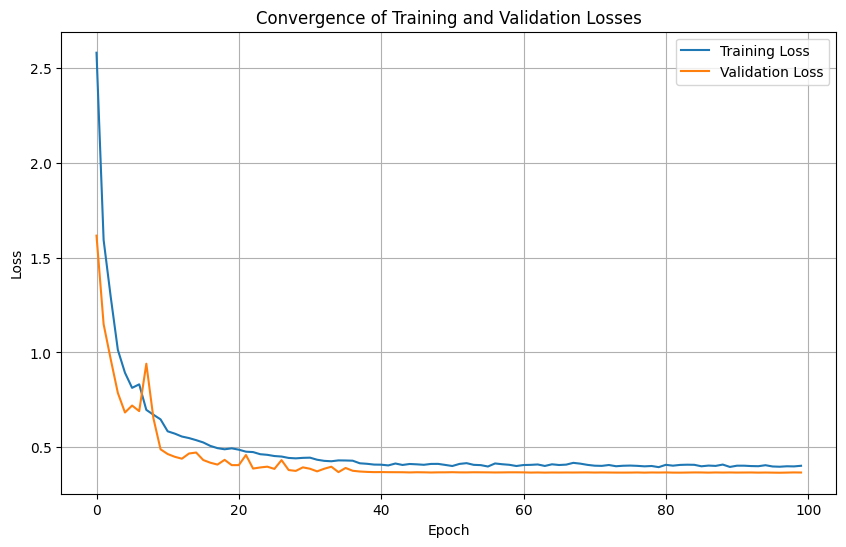

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Convergence of Training and Validation Losses")
plt.legend()
plt.grid()
plt.show()


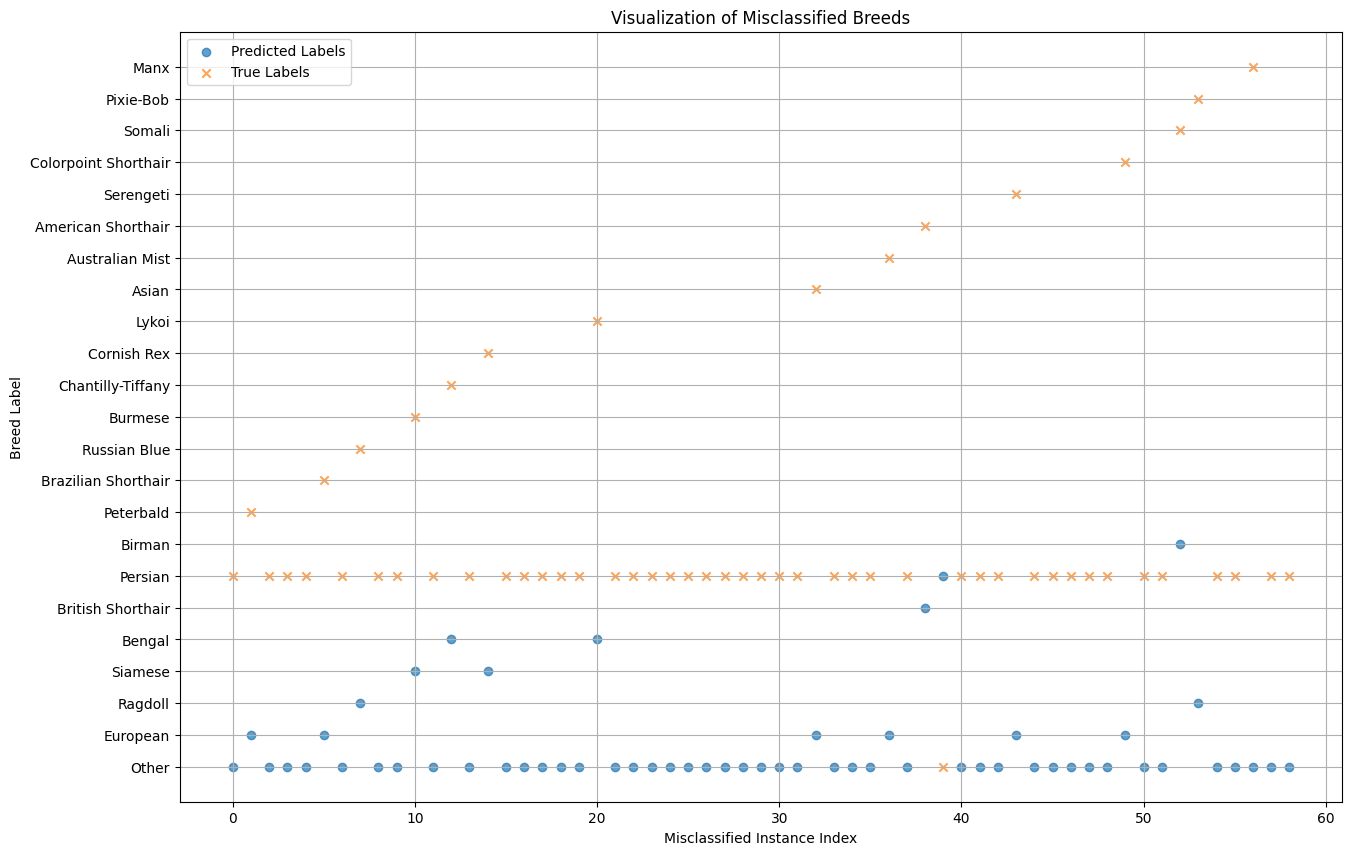

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

predictions = np.argmax(softmax(relu(relu(test_X @ W1 + b1) @ W2 + b2) @ W3 + b3), axis=1)
true_labels = np.argmax(test_Y, axis=1)
misclassified = predictions != true_labels

try:
    misclassified_indices = np.where(misclassified)[0]
    misclassified_data = test_X[misclassified_indices]
    misclassified_pred_labels = predictions[misclassified_indices]
    misclassified_true_labels = true_labels[misclassified_indices]

    misclassified_pred_breeds = [label_to_breed[label] for label in misclassified_pred_labels]
    misclassified_true_breeds = [label_to_breed[label] for label in misclassified_true_labels]


    plt.figure(figsize=(15, 10))
    plt.scatter(
        range(len(misclassified_indices)),
        misclassified_pred_breeds,
        label="Predicted Labels",
        alpha=0.7,
        marker='o'
    )
    plt.scatter(
        range(len(misclassified_indices)),
        misclassified_true_breeds,
        label="True Labels",
        alpha=0.7,
        marker='x'
    )
    plt.xlabel("Misclassified Instance Index")
    plt.ylabel("Breed Label")
    plt.title("Visualization of Misclassified Breeds")
    plt.legend()
    plt.grid()
    plt.show()

except NameError as e:
    print("Error: Missing variables or definitions in the context. Ensure earlier steps have been executed.")
    print(e)


## 2. Read a natural language description of a cat, extract relevant attributes and identify its breed.

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re


lemmatizer = WordNetLemmatizer()

raw_attribute_list = [

    "Sex", "Age", "Breed", "Number", "Accommodation", "Area",


    "Shy", "Calm", "Afraid", "Clever", "Vigilant", "Persevering",
    "Affectionate", "Friendly", "Lonely", "Brutal", "Dominant",
    "Aggressive", "Impulsive", "Predictable", "Distracted",


    "Ext", "Obs", "Abundance", "PredBird", "PredMamm",


    "length", "origin", "min_life_expectancy", "max_life_expectancy",
    "min_weight", "max_weight",


    "family_friendly", "shedding", "general_health", "playfulness",
    "children_friendly", "grooming", "intelligence", "other_pets_friendly"
]


attribute_list = [lemmatizer.lemmatize(attr.lower()) for attr in raw_attribute_list]


attribute_mapping = {
    "playfulness": ["playful", "energetic", "fun"],
    "intelligence": ["intelligent", "smart", "clever"],
    "friendly": ["sociable", "playful", "outgoing"],
    "affectionate": ["loving", "cuddly", "caring"],
    "calm": ["peaceful", "relaxed"],
    "aggressive": ["hostile", "violent", "not calm"],
}


opposite_attributes = {
    "calm": "aggressive",
    "aggressive": "calm",
    "aggressive": "friendly",
    "friendly": "aggressive",
    "affectionate": "lonely",
    "lonely": "affectionate"
}

intensity_mapping = {
    "very": 5,
    "extremely": 5,
    "highly": 5,
    "somewhat": 3,
    "moderately": 3,
    "slightly": 2,
    "barely": 1,
    "hardly": 1,
}

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemmatizer.lemmatize(lemma.name().replace("_", " ").lower()))
    return synonyms


def parse_text_to_attributes(text, attributes):
    extracted_attributes = {}
    updates_for_opposites = {}

    lemmatized_text = " ".join([lemmatizer.lemmatize(word.lower()) for word in re.findall(r'\w+', text)])
    print(f"Lemmatized Text: {lemmatized_text}")

    for attribute in attributes:
        synonyms = set(attribute_mapping.get(attribute, [])) | get_synonyms(attribute)

        for synonym in synonyms:
            pattern = rf"(?:(not|neither|nor|barely|hardly|somewhat|very|extremely|moderately|slightly)\s+)?\b{synonym}\b"
            matches = re.finditer(pattern, text, re.IGNORECASE)

            for match in matches:
                intensity = match.group(1)
                if intensity in {"not", "neither", "nor"}:
                    extracted_attributes[attribute] = 0
                elif intensity in intensity_mapping:
                    extracted_attributes[attribute] = intensity_mapping[intensity]
                else:
                    extracted_attributes[attribute] = 3


    for attr, value in extracted_attributes.items():
        if attr in opposite_attributes:
            opposite = opposite_attributes[attr]
            updates_for_opposites[opposite] = max(0, 5 - value)

    extracted_attributes.update(updates_for_opposites)

    return extracted_attributes


def prepare_input_vector(parsed_attributes, feature_columns):
    input_vector = np.zeros(len(feature_columns))
    for attribute, value in parsed_attributes.items():
        if attribute in feature_columns:
            index = feature_columns.index(attribute)
            input_vector[index] = value
    return input_vector


def normalize_input(input_vector, max_values):
    return input_vector / max_values


def predict_breed(input_vector, W1, b1, W2, b2, W3, b3):
    z1 = relu(input_vector @ W1 + b1)
    z2 = relu(z1 @ W2 + b2)
    y_pred = softmax(z2 @ W3 + b3)
    return np.argmax(y_pred), y_pred



def breed_mapping_prediction(description):

  parsed_attributes = parse_text_to_attributes(description, attribute_list)
  print(f"Parsed Attributes: {parsed_attributes}")
  feature_columns = augmented_df.drop(columns=["Breed"]).columns.tolist()
  max_values = np.max(X, axis=0)
  input_vector = prepare_input_vector(parsed_attributes, feature_columns)
  predicted_label, predicted_probs = predict_breed(input_vector, W1, b1, W2, b2, W3, b3)
  predicted_breed = label_to_breed.get(predicted_label, "Unknown")
  return predicted_breed
  #print(f"Predicted Breed: {predicted_breed}")
  #print(f"Prediction Probabilities: {predicted_probs}")

In [ ]:
input_text_1 = "The cat can be a little aggressive at times but is generally calm and friendly. It has a short coat and loves being outdoors."
print(f"Prediction 1: {breed_mapping_prediction(input_text_1)}")

input_text_2 = "The cat is extremely affectionate, highly playful, and very intelligent. It is perfect for families."
print(f"Prediction 2: {breed_mapping_prediction(input_text_2)}")

input_text_3 = "This cat is barely friendly, hardly playful, and not very affectionate. It seems shy and reserved."
print(f"Prediction 3: {breed_mapping_prediction(input_text_3)}")

input_text_4 = "The cat is friendly but a little aggressive. It is quite affectionate and clever but gets distracted easily. It is impulsive, but sometimes lonely."
print(f"Prediction 4: {breed_mapping_prediction(input_text_4)}")



Lemmatized Text: the cat can be a little aggressive at time but is generally calm and friendly it ha a short coat and love being outdoors
Parsed Attributes: {'calm': 3, 'friendly': 2, 'aggressive': 2}
Prediction 1: Bengal
Lemmatized Text: the cat is extremely affectionate highly playful and very intelligent it is perfect for family
Parsed Attributes: {'affectionate': 5, 'friendly': 3, 'playfulness': 3, 'intelligence': 5, 'lonely': 0, 'aggressive': 2}
Prediction 2: European
Lemmatized Text: this cat is barely friendly hardly playful and not very affectionate it seems shy and reserved
Parsed Attributes: {'shy': 3, 'affectionate': 5, 'friendly': 1, 'playfulness': 1, 'lonely': 0, 'aggressive': 4}
Prediction 3: Bengal
Lemmatized Text: the cat is friendly but a little aggressive it is quite affectionate and clever but get distracted easily it is impulsive but sometimes lonely
Parsed Attributes: {'clever': 3, 'affectionate': 2, 'friendly': 2, 'lonely': 2, 'aggressive': 2, 'impulsive': 3, 'dis


# Generate a natural language description of a cat breed using the trained classifiers.


---





In [ ]:
attribute_importance = np.sum(np.abs(W1), axis=1)


top_k = 10
important_indices = np.argsort(attribute_importance)[-top_k:]


attribute_names = augmented_df.drop(columns=['Breed']).columns
important_attributes = [attribute_names[i] for i in important_indices]

print(f"Selected Important Attributes: {important_attributes}")

Selected Important Attributes: ['min_weight', 'Ext', 'playfulness', 'general_health', 'family_friendly', 'other_pets_friendly', 'length', 'origin', 'grooming', 'shedding']


In [ ]:
import numpy as np
import pandas as pd
import random


attribute_description_mapping = {
    "general_health": {
        "high": [
            "This breed is generally very healthy and resilient.",
            "This breed rarely faces health problems and has excellent vitality."
        ],
        "low": [
            "This breed is prone to certain health issues and requires extra care.",
            "This breed may experience frequent health concerns and needs attentive care."
        ]
    },
    "family_friendly": {
        "high": [
            "This breed is excellent with families and children.",
            "It is a wonderful companion for families and adapts well to children."
        ],
        "low": [
            "This breed may not be the best choice for families with small children.",
            "It prefers a quieter environment and might not be ideal for families with young kids."
        ]
    },
    "other_pets_friendly": {
        "high": [
            "This breed gets along well with other pets.",
            "It is sociable and enjoys the company of other pets."
        ],
        "low": [
            "This breed prefers to be the only pet in the household.",
            "It may not tolerate other pets well and thrives best as the sole pet."
        ]
    },
    "grooming": {
        "high": [
            "This breed requires frequent grooming to maintain its coat.",
            "Regular grooming sessions are essential for this breed."
        ],
        "low": [
            "This breed is low-maintenance and requires minimal grooming.",
            "It needs only occasional grooming and is easy to care for."
        ]
    },
    "shedding": {
        "high": [
            "This breed is known for heavy shedding and may require regular cleaning.",
            "Frequent shedding means extra cleaning efforts are necessary."
        ],
        "low": [
            "This breed sheds minimally and is easier to maintain.",
            "Low shedding makes it a great choice for clean households."
        ]
    },
    "min_weight": {
        "high": [
            "This breed typically has a larger build and weighs more.",
            "It is a sturdy breed with a heavier frame."
        ],
        "low": [
            "This breed is small and lightweight.",
            "It is compact and easy to handle due to its smaller size."
        ]
    },
    "length": {
        "high": [
            "This breed has a long body and sleek appearance.",
            "It is known for its elongated frame and elegant build."
        ],
        "low": [
            "This breed is compact and smaller in stature.",
            "Its short and sturdy build gives it a unique charm."
        ]
    },
    "Ext": {
        "high": [
            "This breed tends to thrive outdoors, enjoying freedom and open spaces.",
            "It is well-suited for outdoor life and loves exploring its surroundings."
        ],
        "low": [
            "This breed prefers indoor environments and close companionship.",
            "It is happiest when spending time indoors with its owner."
        ]
    }
}


relevant_attributes = list(attribute_description_mapping.keys())

def normalize_column_names(data_frame):
    data_frame.columns = [col.lower() for col in data_frame.columns]
    return data_frame

def generate_description_from_attributes(attribute_values):
    description_parts = []
    for attribute, value in attribute_values.items():
        if attribute in attribute_description_mapping:
            if value > 3:
                descriptions = attribute_description_mapping[attribute].get("high", ["High attribute description missing."])
                description_parts.append(random.choice(descriptions))
            elif value <= 2:
                descriptions = attribute_description_mapping[attribute].get("low", ["Low attribute description missing."])
                description_parts.append(random.choice(descriptions))
    return " ".join(description_parts)


def get_breed_description(breed_id, data_frame):
    data_frame = normalize_column_names(data_frame)

    normalized_relevant_attributes = [attr.lower() for attr in relevant_attributes]

    breed_rows = data_frame[data_frame["breed"] == breed_id]

    if breed_rows.empty:
        return f"No data found for the breed ID: {breed_id}"

    missing_attributes = set(normalized_relevant_attributes) - set(data_frame.columns)
    if missing_attributes:
        return f"Missing attributes in dataset: {missing_attributes}"

    avg_attributes = breed_rows[normalized_relevant_attributes].mean().to_dict()

    if not any(avg_attributes.values()):
        return f"No valid attributes found for the breed ID: {breed_id}"

    description = generate_description_from_attributes(avg_attributes)

    data_frame = normalize_column_names(data_frame)
    normalized_relevant_attributes = [attr.lower() for attr in relevant_attributes]
    breed_rows = data_frame[data_frame["breed"] == breed_id]
    origin_value = breed_rows['origin'].values[0]
    origin_description = label_to_origin_mapping.get(origin_value, "Unknown origin")
    final_description = f"{description} This breed originates from {origin_description}."
    #print(f"Avg_attributes: {avg_attributes}")

    if not final_description.strip():
        final_description = "This breed has unique characteristics and is a wonderful companion."

    return f"Breed ID: {breed_id}\nDescription: {final_description}"


def describe_all_breeds(df, breed_to_label):
    for breed_name, breed_id in breed_to_label.items():
        print(f"Breed: {breed_name}")
        description = get_breed_description(breed_id, df)
        print(description)
        print("-" * 60)

def describe_one_breed(df,breed_name):
      print(f"Breed: {breed_name}")
      description = get_breed_description(breed_to_label[breed_name], df)
      print(description)
      print("-" * 60)


csv_file_path = "augmented_dataset.csv"
df = pd.read_csv(csv_file_path)
df = normalize_column_names(df)


In [ ]:
#describe_all_breeds(df, breed_to_label)
describe_one_breed(df, "Siamese Cat")

Breed: Siamese Cat
Breed ID: 55
Description: It is a wonderful companion for families and adapts well to children. It is sociable and enjoys the company of other pets. Regular grooming sessions are essential for this breed. This breed sheds minimally and is easier to maintain. It is a sturdy breed with a heavier frame. It is known for its elongated frame and elegant build. This breed originates from Thailand.
------------------------------------------------------------


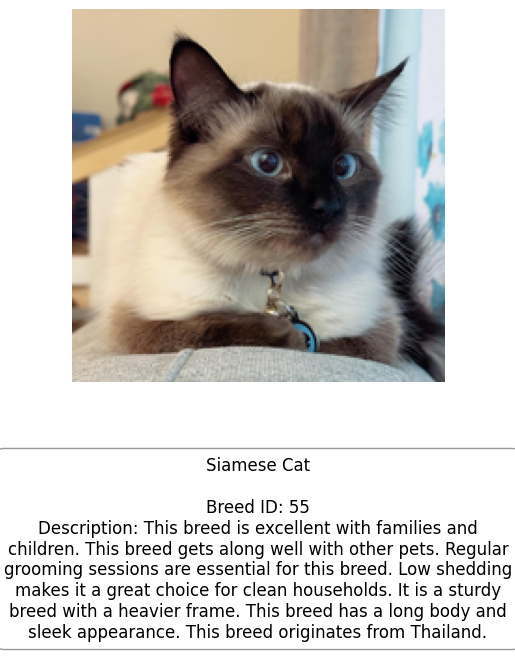

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage

breed_images = [
    {"breed_name": "Abyssinian", "image_url": "img/abyssinian.jpg"},
    {"breed_name": "Aegean", "image_url": "img/aegean.jpg"},
    {"breed_name": "American Bobtail", "image_url": "img/americanbobtail.jpg"},
    {"breed_name": "American Shorthair", "image_url": "img/americanshorthair.jpg"},
    {"breed_name": "American Wirehair", "image_url": "img/americanwirehair.jpg"},
    {"breed_name": "Aphrodite Giant", "image_url": "img/aphroditegiant.jpg"},
    {"breed_name": "Arabian Mau", "image_url": "img/arabianmau.jpg"},
    {"breed_name": "Asian", "image_url": "img/asian.png"},
    {"breed_name": "Australian Mist", "image_url": "img/australianmist.jpg"},
    {"breed_name": "Bambino", "image_url": "img/bambino.jpg"},
    {"breed_name": "Bengal", "image_url": "img/bengal.jpg"},
    {"breed_name": "Bengal Cats", "image_url": "img/bengal.jpg"},
    {"breed_name": "Birman", "image_url": "img/birman.jpg"},
    {"breed_name": "Bombay", "image_url": "img/bombay.jpg"},
    {"breed_name": "Brazilian Shorthair", "image_url": "img/brazilian.jpg"},
    {"breed_name": "British Longhair", "image_url": "img/britishl.png"},
    {"breed_name": "British Shorthair", "image_url": "img/britishs.png"},
    {"breed_name": "Burmese", "image_url": "img/burmese.jpg"},
    {"breed_name": "Burmilla", "image_url": "img/burmilla.jpg"},
    {"breed_name": "California Spangled", "image_url": "img/california.jpg"},
    {"breed_name": "Chantilly-Tiffany", "image_url": "img/chantilly.jpeg"},
    {"breed_name": "Chartreux", "image_url": "img/chartreux.jpg"},
    {"breed_name": "Chausie", "image_url": "img/chausie.jpg"},
    {"breed_name": "Colorpoint Shorthair", "image_url": "img/colorpoint.jpg"},
    {"breed_name": "Cornish Rex", "image_url": "img/cornish.jpg"},
    {"breed_name": "Cyprus", "image_url": "img/cyprus.jpg"},
    {"breed_name": "Devon Rex", "image_url": "img/devon.jpg"},
    {"breed_name": "Donskoy", "image_url": "img/donskoy.jpg"},
    {"breed_name": "European", "image_url": "img/european.jpg"},
    {"breed_name": "European Shorthair", "image_url": "img/europeans.jpg"},
    {"breed_name": "Foldex", "image_url": "img/foldex.jpg"},
    {"breed_name": "German Rex", "image_url": "img/german.jpg"},
    {"breed_name": "Highlander", "image_url": "img/highlander.jpg"},
    {"breed_name": "Japanese Bobtail", "image_url": "img/japanese.jpeg"},
    {"breed_name": "Javanese", "image_url": "img/javanese.jpg"},
    {"breed_name": "Khao Manee", "image_url": "img/khao.jpg"},
    {"breed_name": "Kurilian Bobtail", "image_url": "img/kurilian.jpg"},
    {"breed_name": "Lykoi", "image_url": "img/lykoi.jpg"},
    {"breed_name": "Maine coon", "image_url": "img/mainec.jpg"},
    {"breed_name": "Manx", "image_url": "img/manx.jpg"},
    {"breed_name": "Mekong Bobtail", "image_url": "img/mekong.jpg"},
    {"breed_name": "Nebelung", "image_url": "img/nebelung.jpeg"},
    {"breed_name": "Oriental Bicolor", "image_url": "img/oriental.jpg"},
    {"breed_name": "Persian", "image_url": "img/persian.jpg"},
    {"breed_name": "Peterbald", "image_url": "img/peterbald.jpg"},
    {"breed_name": "Pixie-Bob", "image_url": "img/pixie.jpg"},
    {"breed_name": "Ragdoll", "image_url": "img/ragdoll.jpg"},
    {"breed_name": "Ragdoll Cats", "image_url": "img/ragdoll.jpg"},
    {"breed_name": "Russian Blue", "image_url": "img/russian.jpg"},
    {"breed_name": "Savannah", "image_url": "img/savannah.jpeg"},
    {"breed_name": "Scottish Fold", "image_url": "img/scottish.jpg"},
    {"breed_name": "Serengeti", "image_url": "img/serengeti.jpg"},
    {"breed_name": "Siamese", "image_url": "img/siamese.jpg"},
    {"breed_name": "Siamese Cat", "image_url": "img/siamese.jpg"},
    {"breed_name": "Siberian", "image_url": "img/siberian.jpg"},
    {"breed_name": "Singapura", "image_url": "img/singapura.jpg"},
    {"breed_name": "Snowshoe", "image_url": "img/snowshoe.jpg"},
    {"breed_name": "Sokoke", "image_url": "img/sokoke.png"},
    {"breed_name": "Somali", "image_url": "img/somali.jpg"},
    {"breed_name": "Sphynx", "image_url": "img/sphynx.jpg"},
    {"breed_name": "Tonkinese", "image_url": "img/tonkinese.jpg"},
    {"breed_name": "Toyger", "image_url": "img/toyger.jpg"},
    {"breed_name": "Turkish Angora", "image_url": "img/turkisha.jpg"},
    {"breed_name": "Turkish Van", "image_url": "img/turkishv.jpg"},
    {"breed_name": "Ukrainian Levkoy", "image_url": "img/levkoy.jpg"},
    {"breed_name": "York Chocolate", "image_url": "img/york.jpg"}

]

def print_breed_description_and_image(breed_name):

  #breed_name = "Somali"
  breed_id = breed_to_label[breed_name]

  breed_data = next((breed for breed in breed_images if breed_to_label[breed["breed_name"]] == breed_id), None)

  if not breed_data:
      print(f"No breed found for ID {breed_id}.")

  breed_name = breed_data["breed_name"]
  image_url = breed_data["image_url"]


  description = get_breed_description(breed_id, df)


  img = PILImage.open(image_url)
  img_resized = img.resize((200, 200), PILImage.Resampling.LANCZOS)


  fig, ax = plt.subplots(figsize=(5, 7))
  ax.imshow(img_resized)
  ax.axis('off')


  plt.text(
      0.5, -0.2,
      f"{breed_name}\n\n{description}",
      fontsize=12,
      ha='center',
      va='top',
      wrap=True,
      transform=ax.transAxes,
      bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5')
  )

  plt.tight_layout()
  plt.show()


print_breed_description_and_image('Siamese Cat')

In [ ]:
relevant_attributes_for_comparison = [
        "shy", "calm", "afraid", "clever", "vigilant", "persevering",
        "affectionate", "friendly", "lonely", "brutal", "dominant",
        "aggressive", "impulsive", "predictable", "distracted",
        "length", "origin", "min_life_expectancy", "max_life_expectancy",
        "min_weight", "max_weight", "family_friendly", "shedding",
        "general_health", "playfulness", "children_friendly",
        "grooming", "intelligence", "other_pets_friendly"
    ]

attribute_phrasing = {
    "shy": "shyness",
    "calm": "calm temperament",
    "afraid": "fearfulness",
    "clever": "intelligence",
    "vigilant": "alertness",
    "persevering": "determination",
    "affectionate": "affection",
    "friendly": "friendliness",
    "lonely": "tendency to feel lonely",
    "brutal": "brutality",
    "dominant": "dominance",
    "aggressive": "aggressiveness",
    "impulsive": "impulsiveness",
    "predictable": "predictability",
    "distracted": "easily distracted nature",
    "length": "body length",
    "origin": "place of origin",
    "min_life_expectancy": "minimum life expectancy",
    "max_life_expectancy": "maximum life expectancy",
    "min_weight": "minimum weight",
    "max_weight": "maximum weight",
    "family_friendly": "suitability for families",
    "shedding": "shedding level",
    "general_health": "overall health",
    "playfulness": "playfulness",
    "children_friendly": "friendliness towards children",
    "grooming": "grooming needs",
    "intelligence": "intelligence",
    "other_pets_friendly": "friendliness towards other pets"
}

def compare_breeds(breed1_name, breed2_name, breed_to_label, data_frame):
    data_frame = normalize_column_names(data_frame)
    normalized_relevant_attributes = [attr.lower() for attr in relevant_attributes_for_comparison]

    breed1_id = breed_to_label.get(breed1_name)
    breed2_id = breed_to_label.get(breed2_name)

    if breed1_id is None or breed2_id is None:
        return f"One or both breed names not found in breed_to_label. Available breeds: {list(breed_to_label.keys())}"


    breed1_rows = data_frame[data_frame["breed"] == breed1_id]
    breed2_rows = data_frame[data_frame["breed"] == breed2_id]

    if breed1_rows.empty or breed2_rows.empty:
        return f"One or both breeds not found in the dataset. Breed1: {breed1_name}, Breed2: {breed2_name}"


    breed1_avg_attributes = breed1_rows[normalized_relevant_attributes].mean().to_dict()
    breed2_avg_attributes = breed2_rows[normalized_relevant_attributes].mean().to_dict()

    comparison_parts = set()
    for attribute in relevant_attributes_for_comparison:
        display_attribute = attribute_phrasing.get(attribute, attribute.replace('_', ' '))
        breed1_value = breed1_avg_attributes.get(attribute.lower(), None)
        breed2_value = breed2_avg_attributes.get(attribute.lower(), None)

        if breed1_value is None or breed2_value is None:
            continue

        if attribute == "length":
            if breed1_value > breed2_value:
                comparison_parts.add(f"{breed1_name} has a longer body compared to {breed2_name}.")
            elif breed1_value < breed2_value:
                comparison_parts.add(f"{breed2_name} has a longer body compared to {breed1_name}.")
            else:
                comparison_parts.add(f"Both breeds have a similar body length.")

        elif attribute == "origin":
            if label_to_origin_mapping[breed1_value] == label_to_origin_mapping[breed1_value]:
              comparison_parts.add(f"Both breeds originate from {label_to_origin_mapping[breed1_value]}.")
            else:
              comparison_parts.add(f"{breed1_name} originates from {label_to_origin_mapping[breed1_value]}, while {breed2_name} originates from {label_to_origin_mapping[breed2_value]}.")

        elif attribute in ["min_life_expectancy", "max_life_expectancy"]:
            if breed1_value > breed2_value:
                comparison_parts.add(f"{breed1_name} tends to live longer than {breed2_name}.")
            elif breed1_value < breed2_value:
                comparison_parts.add(f"{breed2_name} tends to live longer than {breed1_name}.")
            else:
                comparison_parts.add(f"Both breeds have a similar life expectancy.")

        elif attribute == "overall_health":
            if breed1_value > breed2_value:
                comparison_parts.add(f"{breed1_name} has better overall health compared to {breed2_name}.")
            elif breed1_value < breed2_value:
                comparison_parts.add(f"{breed2_name} has better overall health compared to {breed1_name}.")
            else:
                comparison_parts.add(f"Both breeds have similar overall health.")

        elif attribute == "grooming":
            if breed1_value > breed2_value:
                comparison_parts.add(f"{breed1_name} requires more grooming compared to {breed2_name}.")
            elif breed1_value < breed2_value:
                comparison_parts.add(f"{breed2_name} requires more grooming compared to {breed1_name}.")
            else:
                comparison_parts.add(f"Both breeds have similar grooming needs.")

        elif attribute == "shedding":
            if breed1_value > breed2_value:
                comparison_parts.add(f"{breed1_name} sheds more compared to {breed2_name}.")
            elif breed1_value < breed2_value:
                comparison_parts.add(f"{breed2_name} sheds more compared to {breed1_name}.")
            else:
                comparison_parts.add(f"Both breeds have similar shedding levels.")

        elif attribute in ["min_weight", "max_weight"]:
            if breed1_value > breed2_value:
                comparison_parts.add(f"{breed1_name} is generally heavier than {breed2_name}.")
            elif breed1_value < breed2_value:
                comparison_parts.add(f"{breed2_name} is generally heavier than {breed1_name}.")
            else:
                comparison_parts.add(f"Both breeds have a similar weight.")

        elif attribute == "lonely":
            if breed1_value > breed2_value:
                comparison_parts.add(f"{breed1_name} is more likely to feel lonely compared to {breed2_name}.")
            elif breed1_value < breed2_value:
                comparison_parts.add(f"{breed2_name} is more likely to feel lonely compared to {breed1_name}.")
            else:
                comparison_parts.add(f"Both breeds have a similar tendency to feel lonely.")

        elif attribute == "distracted":
            if breed1_value > breed2_value:
                comparison_parts.add(f"{breed1_name} is more easily distracted compared to {breed2_name}.")
            elif breed1_value < breed2_value:
                comparison_parts.add(f"{breed2_name} is more easily distracted compared to {breed1_name}.")
            else:
                comparison_parts.add(f"Both breeds have a similar level of focus.")
        else:
            if breed1_value > 3 and breed2_value > 3:
                comparison_parts.add(f"Both breeds excel in {display_attribute}.")
            elif breed1_value <= 2 and breed2_value <= 2:
                comparison_parts.add(f"Both breeds show low levels of {display_attribute}.")
            elif breed1_value > 3 and breed2_value <= 2:
                comparison_parts.add(f"{breed1_name} excels in {display_attribute}, while {breed2_name} scores lower.")
            elif breed1_value <= 2 and breed2_value > 3:
                comparison_parts.add(f"{breed2_name} excels in {display_attribute}, while {breed1_name} scores lower.")
            else:
                comparison_parts.add(f"{breed1_name} and {breed2_name} have moderate levels of {display_attribute}.")

    describe_one_breed(df, breed1_name)
    describe_one_breed(df, breed2_name)

    return (
        f"Comparison of {breed1_name} and {breed2_name}:\n\n"
        f"Key Comparisons:\n" + "\n".join(comparison_parts)
    )

In [ ]:
result = compare_breeds("European", "Asian", breed_to_label, df)
print(result)

Breed: European
Breed ID: 28
Description: This breed is excellent with families and children. It is sociable and enjoys the company of other pets. This breed sheds minimally and is easier to maintain. It is a sturdy breed with a heavier frame. Its short and sturdy build gives it a unique charm. This breed originates from Russia.
------------------------------------------------------------
Breed: Asian
Breed ID: 7
Description: This breed rarely faces health problems and has excellent vitality. It is a wonderful companion for families and adapts well to children. It is sociable and enjoys the company of other pets. This breed sheds minimally and is easier to maintain. It is a sturdy breed with a heavier frame. Its short and sturdy build gives it a unique charm. This breed originates from Great Britain.
------------------------------------------------------------
Comparison of European and Asian:

Key Comparisons:
European and Asian have moderate levels of fearfulness.
Both breeds excel i

In [ ]:
for breed_name, breed_id in breed_to_label.items():
        print(f"Breed: {breed_name}")